# Projeto 1 - Ciência dos Dados

Nome: André Corrêa Santos
Nome: Henrique Damico

___
Carregando algumas bibliotecas:

In [316]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk

In [317]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\marce\Desktop\Cdados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [318]:
filename = 'base_de_dados.xlsx'

In [319]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Classificacao
0,quer fazer sua mulher feliz? come ela e da um ...,2
1,"@kimkataguiri que merda estão inventando, kim ...",0
2,alguém tem o link de spotify hackeado pra iphone?,0
3,@adr1nztte @charlidamelio mn pelo menos eu ain...,0
4,favela venceu e meu iphone tá vindo hj😍😘,1


In [320]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Classificacao
0,meu patrão quer que eu pego o iphone 12 pró ma...,0
1,comprei um m62 e vendi meu iphone me sinto com...,0
2,@omardodeboche @marcosrojerio2 @isabeledacpi e...,0
3,"alguém que tenha o iphone 7 plus, sabe me dize...",0
4,se algum amg gostasse de mim de vdd me dava um...,2


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O produto escolhido foi o Iphone e consideramos tweets que demonstrassem a opinião popular referente ao iphone como sendo os tweets mais relevantes. Especificamente, consideramos a opinião popular quanto à características do próprio iphone, como câmera, bateria (elementos do hardware) e também caracteísticas mais subjetivas como o preço. Importante notar que a opinião pode ser tanto boa ou ruim.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.








definição de funções de limpeza e usando natural language toolkit para remover stopwords, de modo a melhorar a precisão do classificador.


In [321]:
nltk.download('stopwords') #remover stopwords
s_words = nltk.corpus.stopwords.words('portuguese')
s_list = ["de", "é", "á", "à", "ao", "a", "o", "é", "rt", '"', "“", "'", ",", "(", ")", "$", "%", "*", "&", "+", "="] #implementar stemming, palavras com mesmo stem são tratadas como mesma palavra
s_words.extend(s_list)  #remover palavras que se iniciam com @

def cleanup(lista):
        #Função de limpeza que remove caracteres nao desejados e palavras nao desejados de strings de uma lista de strings
    lista_limpa = []
    for string in lista:
        punctuation = '[!-.:?;]'
        pattern = re.compile(punctuation)   #remover pontuação
        text_subbed = re.sub(pattern, '', string)
        text_subbed.lower()
        palavras = text_subbed.split(" ") #separando a string em palavras
        for palavra in palavras:
            if palavra in s_words:      
                palavras.remove(palavra) #removendo as stopwords
            palavra.replace("\n"," ")
        lista_limpa.append(" ".join(palavras))   #transformando a lista resultante em string    

    return lista_limpa


    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


limpando a lista de opiniao, lista não opinião e lista de teste. Importante notar que fizemos 4 categorias no banco de dados, contudo, pela dificuldade de implementação de mais de duas categorias e pela falta de mão de obra, como dupla, julgamos que seria mais prudente trabalhar apenas com duas categorias, para isso estipulamos que o que haviamos marcado como 2 e 3 agora será 1 e o que foi marcado como 0 e 1 é 0.

In [322]:

opiniao = train.loc[(train["Classificacao"] == 3) | (train["Classificacao"] == 2),:] #reorganizando as categorias
nao_opiniao = train.loc[(train["Classificacao"] == 0) | (train["Classificacao"] == 1),:]


texto_opiniao_limpo = cleanup(opiniao["Treinamento"].to_list()) #aplicando função de limpeza
texto_nao_opiniao_limpo = cleanup(nao_opiniao["Treinamento"].to_list())


palavras_opiniao = " ".join(texto_opiniao_limpo).split(" ")  #transformando listas de tweets limpos em listas de palavras contendo todas as palavras dos tweets
palavras_nao_opiniao = " ".join(texto_nao_opiniao_limpo).split(" ") 

palavras_opiniao = [w for w in palavras_opiniao if w not in s_words] 
palavras_nao_opiniao = [w for w in palavras_nao_opiniao if w not in s_words]

teste = []

for tweet in test["Teste"]:
    tweet = cleanup(tweet.split(" "))
    palavras_tweet = tweet
    palavras_tweet = [w for w in palavras_tweet if w not in s_words]
    teste.append(" ".join(palavras_tweet))    #limpando tweets da lista de testes


pegando listas relativas e absolutas

In [323]:

lista_palavras_absoluta_opiniao = pd.Series(palavras_opiniao).value_counts()  #contando frequências absoluta e relativa, respectivamente, das palavras em tanto a categoria opinião quanto não opinião.
lista_palavras_relativa_opiniao = pd.Series(palavras_opiniao).value_counts(normalize=True)

lista_palavras_absoluta_nao_opiniao = pd.Series(palavras_nao_opiniao).value_counts()
lista_palavras_relativa_nao_opiniao = pd.Series(palavras_nao_opiniao).value_counts(normalize=True)


Definindo os priors.
Priors são probabilidades à priori (como o nome já implica). Esses coeficientes são obtidos supondo-se que a soma das palavras das listas das categorias seja igual à todo o vocabulário português e, portanto, podemos dividir o tamanho da lista de frequências de palavras para cada categoria pelo número de palavras no total e desse modo obtemos o prior de cada categoria. Vale notar que o tamanho da lista de frequências de cada categoria representa o número de palavras diferentes dessa categoria e que a lista de frequência em questão é obtida por meio da função value counts.

In [324]:

total = len(lista_palavras_absoluta_opiniao)+len(lista_palavras_absoluta_nao_opiniao)
prior_op = len(lista_palavras_absoluta_opiniao)/total
prior_nop = len(lista_palavras_absoluta_nao_opiniao)/total  


VERIFICANDO O CLASSIFICADOR COM A BASE DE TESTES - criando função que recebe as listas e priors e efetua a classificação de uma lista de tweets.

In [325]:

 
def classify(lista_de_tweets,lista_palavras_absoluta_opiniao,lista_palavras_absoluta_nao_opiniao,prior_op,prior_nop): #funcao recebe uma lista de tweets, uma lista de frequencia de palavras opiniao, uma lista de frequencia de palavras nao opiniao, numero total de palavras e os priors
    resultado = [] #lista resultado que vai guardar as classificações geradas pelo classificador
    for tweet in lista_de_tweets: #loop que percorre todos os tweets da base de teste
        prob_op =[]   #listas que vão guardar as probabilidades de cada palavra dentro do tweet para caso categoria opinião e caso categoria não opinião
        prob_nop =[]
        for palavra in tweet:
            prob_dado_opiniao = 1             #aplicação da suavização de laplace, que garante que para palavras que não existem nos bancos de frequência das categorias, não haverá multiplicação por zero no produto das probabilidades de todas as probabilidades.
            prob_dado_nao_opiniao = 1

            prob_dado_opiniao *= 1/(len(lista_palavras_absoluta_opiniao)+total)
            prob_dado_nao_opiniao *= 1/(len(lista_palavras_absoluta_nao_opiniao)+total)
            if palavra in lista_palavras_absoluta_nao_opiniao:

                prob_dado_nao_opiniao += (lista_palavras_absoluta_nao_opiniao[palavra])/(len(lista_palavras_absoluta_nao_opiniao)+total)

            if palavra in lista_palavras_absoluta_opiniao:

                prob_dado_opiniao += (lista_palavras_absoluta_opiniao[palavra])/(len(lista_palavras_absoluta_opiniao)+total)

            prob_op.append(prob_dado_opiniao)
            prob_nop.append(prob_dado_nao_opiniao)

            prob_opiniao_dado_frase =  np.prod(prob_op)*prior_op  #calculo das probabilidades de opiniao dado tweet e nao opiniao dado tweet. Obtidos pelo produto das probabilidades de todas as palavras dado opiniao ou nao opiniao e, por fim, multiplica se o resultado desse grande produto pelos respectivos priors.
            prob_nao_opiniao_dado_frase = np.prod(prob_nop)*prior_nop

        if prob_opiniao_dado_frase > prob_nao_opiniao_dado_frase: #efetua-se a classificação avaliando qual das probabilidades dado frase é maior.
            resultado.append(1)
        else:
            resultado.append(0)
    return resultado


test["resultados"] = classify(teste,lista_palavras_absoluta_opiniao,lista_palavras_absoluta_nao_opiniao,prior_op,prior_nop) #criando uma nova coluna no dataframe de testes, que guarda o resultado da classificação



In [326]:
serie_conv = []
for i in test["Classificacao"].to_list(): #transformando os 2 e 3 em 1 e os 0 e 1 em 0 na base de testes. Visto que apenas usamos um classificador de duas categorias.
    if i == 2 or i == 3:
        serie_conv.append(1)
    if i == 0 or i == 1:
        serie_conv.append(0)
classific = pd.Series(serie_conv)

Calculando os acertos. Comparando as classificacoes na base de teste e as classificacoes geradas pelo classificador. Calculando, acurácia, falsos positivos e negativos e verdadeiros positivos e negativos.

In [327]:
lista_teste = [i for i in classific] 
lista_results = [i for i in test["resultados"]]


contador = 0
verd_pos = 0
verd_neg = 0
falso_pos = 0
falso_neg = 0

for i in range(len(lista_teste)):
    if lista_teste[i] == 1 and lista_results[i] == 1:
        verd_pos += 1
    if lista_teste[i] == 0 and  lista_results[i] == 0:
        verd_neg += 1
    if lista_teste[i] == 0 and lista_results[i] == 1:
        falso_pos += 1
    if lista_teste[i] ==  1 and lista_results[i] == 0:
        falso_neg += 1
    if lista_teste[i] == lista_results[i]:
        contador += 1

acertos = contador/len(lista_teste)
acertos *= 100
positivos = verd_pos + falso_pos
negativos = verd_neg + falso_neg
verd_pos /= positivos   #quantidade de verdadeiros positivos dividido pelo numero de positivos
verd_neg /= negativos
falso_pos /= positivos
falso_neg /= negativos


print("Acurácia: "+str(acertos)+"%")
print("Falsos positivos: "+str(falso_pos*100)+"%")
print("Falsos negativos: "+str(falso_neg*100)+"%")
print("verdadeiros positivos: "+str(verd_pos*100)+"%")
print("verdadeiros negativos: "+str(verd_neg*100)+"%")

Acurácia: 74.0%
Falsos positivos: 94.73684210526315%
Falsos negativos: 13.679245283018867%
verdadeiros positivos: 5.263157894736842%
verdadeiros negativos: 86.32075471698113%


CONCLUSAO


Primeiramente, nota-se que os objetivos estipulados foram antigidos. Foi obtido um classificador de acurácia razoável (para seu algoritmo de classificação). É evidente que não se pode usar de dados classificados pelo próprio classificador para ampliar seu banco de dados de palavras, visto que, caso o classificador erre, o erro em questão será inserido no banco de dados dele mesmo e, deste modo, ele torna-se propenso a repetir esse erro no futuro e, ainda, as certezas são corrompidas.

Para além da classificação de tweets, nota-se que este modelo de classificador pode ser útil na detecção de emails do tipo spam, visto que, munido de um bom banco de treino, ele é capaz de encontrar a probabilidade de dado email ser spam dado as palavras do mesmo email.
Além disso, classificadores do tipo bayes são ótimos para filtrar grandes bancos de dados- por sua rapidez e acurácia satisfatória.
Algumas maneiras triviais de melhorarmos a acurácia do classificador são aumentar o tamanho da base de dados de treinamento e utilizar criterios mais específicos de classificação de relevância das mensagens.

No entanto, ainda é possível ir muito além: é feliz, nesse caso, a utilização de logaritmos em vez de probabilidade em decimais. No caso do classificador de Bayes as multiplicações envolvem valores muito próximos de 0 e, após um número considerável das mesmas, o produto torna-se um número de módulo muito pequeno. Frente a isso, o computador pode ter dificuldades de guardar e comparar tais valores. Por conta das propriedades de logaritmo e comportamento do gráfico da função no intervalo entre 0 e 1, ao utilizarmos os respectivos logaritmos de cada valor de probabilidade nas multiplicações, deixamos de multiplicar números muito próximos de 0 e passamos a usar valores de módulo grande. Ou seja, a situação de o computador ser obrigado a trabalhar com valores baixíssimos inverte-se, podendo trazer resultados mais exatos.
Ademais, outra possível melhora para o classificador Naive Bayes padrão consiste da filtragem de stopwords, como foi implementado nesse projeto.


___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

Criando um df com todos os tweets e classificacao

In [328]:
total_tweets = train["Treinamento"].append(test["Teste"])
total_tweet_classificacao = train["Classificacao"].append(test["Classificacao"])
total_df = pd.concat([total_tweets,total_tweet_classificacao],axis=1)

A acurácia média dos classificadores é: 73.9319%
A acurácia máxima do classificador foi: 85.0%
A acurácia mínima do classificador foi: 64.0%
A porcentagem máxima de verdadeiro positivo foi: 8.0%
A porcentagem minima de verdadeiro positivo foi: 0.0%
A porcentagem máxima de verdadeiro negativo foi: 83.5%
A porcentagem minima de verdadeiro negativo foi: 60.0%


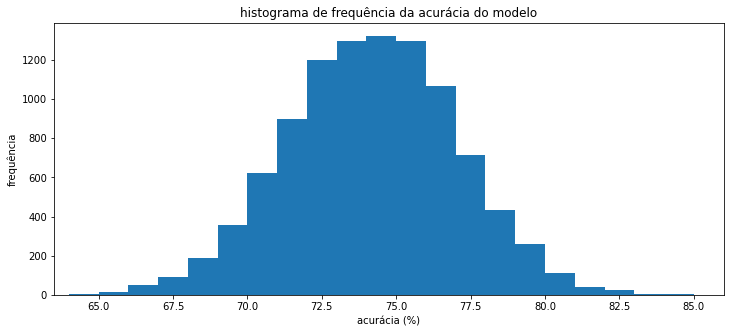

In [329]:
lista_acuracia = [] #criando lista das acuracias de cada classificador
lista_verd_pos = []
lista_verd_neg = []

itera = 10000

for i in range(0,itera):
    df_random = total_df.sample(n=500)
    df_train = df_random.head(300)
    df_teste = df_random.tail(200)
    opiniao = df_train.loc[(df_train["Classificacao"] == 2) |(df_train["Classificacao"] == 3),:]
    nao_opiniao = df_train.loc[(df_train["Classificacao"] == 0) |(df_train["Classificacao"] == 1),:]

    palavras_opiniao = []
    palavras_nao_opiniao = []

    lista_classific_teste = []

    for i in df_teste["Classificacao"]:
        if i == 2 or i == 3:
            lista_classific_teste.append(1)
        if i == 0 or i == 1:
            lista_classific_teste.append(0)


    #limpando listas de treino
    for tweet in opiniao[0]:
        tweet = cleanup(tweet.split(" "))
        palavras_tweet = tweet
        palavras_tweet = [w for w in palavras_tweet if w not in s_words]
        palavras_opiniao.extend(palavras_tweet)

    for tweet in nao_opiniao[0]:
        tweet = cleanup(tweet.split(" "))
        palavras_tweet = tweet
        palavras_tweet = [w for w in palavras_tweet if w not in s_words]
        palavras_nao_opiniao.extend(palavras_tweet)

    #limpando lista de teste
    lista_teste = []

    for tweet in df_teste[0]:
        tweet = cleanup(tweet.split(" "))
        palavras_tweet = tweet
        palavras_tweet = [w for w in palavras_tweet if w not in s_words]
        lista_teste.append(palavras_tweet)
    l2 = []
    for tweet in lista_teste:
        l2.append(list(filter(None,tweet)))
    lista_teste=l2



    palavras_opiniao = list(filter(None,palavras_opiniao))
    palavras_nao_opiniao = list(filter(None,palavras_nao_opiniao))

    lista_palavras_absoluta_opiniao = (pd.Series(palavras_opiniao)).value_counts()
    lista_palavras_absoluta_nao_opiniao = (pd.Series(palavras_nao_opiniao)).value_counts()

    total = len(lista_palavras_absoluta_opiniao) + len(lista_palavras_absoluta_nao_opiniao)

    prior_op = len(lista_palavras_absoluta_opiniao)/total
    prior_nop = len(lista_palavras_absoluta_nao_opiniao)/total

    resultado = classify(lista_teste,lista_palavras_absoluta_opiniao,lista_palavras_absoluta_nao_opiniao,prior_op,prior_nop)

    contador = 0
    verd_pos = 0
    verd_neg = 0

    num = len(lista_classific_teste)

    for i in range(len(lista_classific_teste)):
        if lista_classific_teste[i] == resultado[i]:
            contador += 1
        if lista_classific_teste[i] == 0 and resultado[i] == 0:
            verd_neg += 1
        if lista_classific_teste[i] == 1 and resultado[i] == 1:
            verd_pos += 1
    
    acuracia = (contador/len(lista_classific_teste))*100
    lista_verd_pos.append((verd_pos/num)*100)
    lista_verd_neg.append((verd_neg/num)*100)
    lista_acuracia.append(acuracia)

soma = 0 
for i in lista_acuracia:
    soma += i
acuracia_media = soma/itera

print("A acurácia média dos classificadores é: "+str(acuracia_media)+"%")
print("A acurácia máxima do classificador foi: "+str(max(lista_acuracia))+"%")
print("A acurácia mínima do classificador foi: "+str(min(lista_acuracia))+"%")
print("A porcentagem máxima de verdadeiro positivo foi: "+str(max(lista_verd_pos))+"%")
print("A porcentagem minima de verdadeiro positivo foi: "+str(min(lista_verd_pos))+"%")
print("A porcentagem máxima de verdadeiro negativo foi: "+str(max(lista_verd_neg))+"%")
print("A porcentagem minima de verdadeiro negativo foi: "+str(min(lista_verd_neg))+"%")

faixa=np.arange(min(lista_acuracia)-1,max(lista_acuracia)+1,1)
plt.figure(figsize=(12,5))

plt.hist(lista_acuracia,bins=faixa,density=False)
plt.title("histograma de frequência da acurácia do modelo")
plt.ylabel("frequência")
plt.xlabel("acurácia (%)")
plt.xlim(min(lista_acuracia)-0.5,max(lista_acuracia)+1)
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**